load from sample_hbb.csv
40000 events loaded.
load from sample_q.csv
40000 events loaded.
load from sample_test.csv
40000 events loaded.
Epoch: 1, Accuracy: 0.6975375
Epoch: 2, Accuracy: 0.7399625
Epoch: 3, Accuracy: 0.75305
Epoch: 4, Accuracy: 0.761175
Epoch: 5, Accuracy: 0.8004125
Epoch: 6, Accuracy: 0.81265
Epoch: 7, Accuracy: 0.8136125
Epoch: 8, Accuracy: 0.814625
Epoch: 9, Accuracy: 0.8149125
Epoch: 10, Accuracy: 0.8152625
Epoch: 11, Accuracy: 0.815
Epoch: 12, Accuracy: 0.815525
Epoch: 13, Accuracy: 0.815425
Epoch: 14, Accuracy: 0.8160125
Epoch: 15, Accuracy: 0.8162375
Epoch: 16, Accuracy: 0.816075
Epoch: 17, Accuracy: 0.816575
Epoch: 18, Accuracy: 0.8161875
Epoch: 19, Accuracy: 0.8165875
Epoch: 20, Accuracy: 0.8164
Epoch: 21, Accuracy: 0.815975
Epoch: 22, Accuracy: 0.8161625
Epoch: 23, Accuracy: 0.8162
Epoch: 24, Accuracy: 0.81615
Epoch: 25, Accuracy: 0.8168375
Epoch: 26, Accuracy: 0.8162
Epoch: 27, Accuracy: 0.8164125
Epoch: 28, Accuracy: 0.8165
Epoch: 29, Accuracy: 0.8165625
Ep

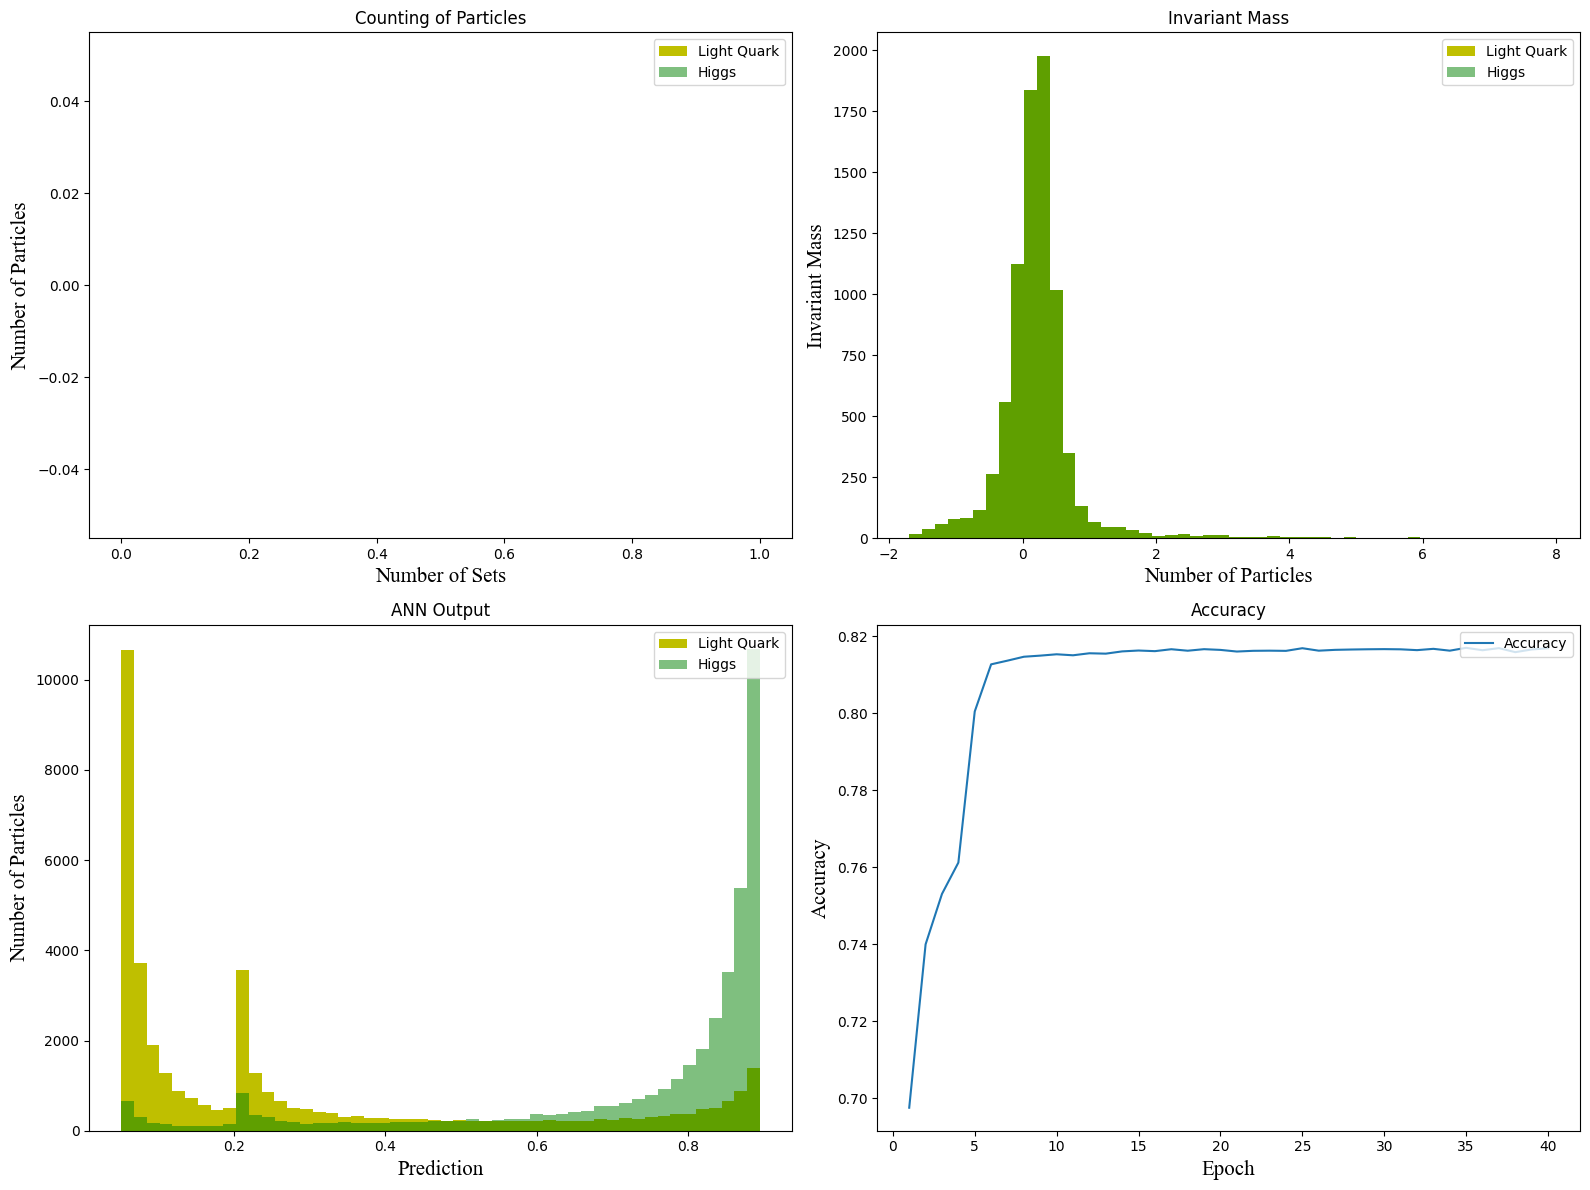

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def load_samples(filename):
    print('load from', filename)
    fin = open(filename)
    lines = fin.readlines()
    idx_cur, samples, evt = -1, [], []
    for l in lines[1:]:
        idx, code, px, py, pz = l.split(',')
        if idx_cur != int(idx):
            idx_cur = int(idx)
            if len(evt) > 0:
                samples.append(evt)
                evt = []
        else:
            evt.append([int(code), float(px), float(py), float(pz)])
    samples.append(evt)
    print(len(samples), 'events loaded.')
    return samples

def prepare_features(samples):
    features = []
    for evt in samples:
        px = py = pz = E = 0.
        for p in evt:
            px += p[1]
            py += p[2]
            pz += p[3]
            E += (p[1]**2 + p[2]**2 + p[3]**2)**0.5
        M = (E**2 - (px**2 + py**2 + pz**2))**0.5
        features.append([len(evt)/100., M/100.])
    return features

class HiggsBosonDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = torch.tensor(x, dtype=torch.float32)
        if y is not None:
            self.y = torch.tensor(y, dtype=torch.float32)
        else:
            self.y = None

    def __getitem__(self, idx):
        if self.y is not None:
            return self.x[idx], self.y[idx]
        else:
            return self.x[idx]

    def __len__(self):
        return len(self.x)

sample_sig = load_samples('sample_hbb.csv')
sample_bkg = load_samples('sample_q.csv')
sample_test = load_samples('sample_test.csv')

x_train = np.array(prepare_features(sample_sig) + prepare_features(sample_bkg))
y_train = np.array([1]*len(sample_sig) + [0]*len(sample_bkg))
x_test = np.array(prepare_features(sample_test))

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

higgs_dataset = HiggsBosonDataset(x_train, y_train)
higgs_loader = DataLoader(higgs_dataset, batch_size=80, shuffle=True)

class HiggsNet(nn.Module):
    def __init__(self):
        super(HiggsNet, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

model = HiggsNet()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

num_of_epoch = 40
accuracy_list = []

for epoch in range(num_of_epoch):
    for batch_idx, (data, target) in enumerate(higgs_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(higgs_loader):
            output = model(data)
            pred = output.squeeze() > 0.5
            correct += pred.eq(target.data).sum().item()
    accuracy = correct / len(higgs_dataset)
    accuracy_list.append(accuracy)
    print("Epoch: {}, Accuracy: {}".format(epoch + 1, accuracy))

x_train = torch.tensor(x_train, dtype=torch.float32)
f_train = model(x_train).detach().numpy()
x_test = torch.tensor(x_test, dtype=torch.float32)
p_test = model(x_test).detach().numpy()

fout = open('my_predicts.csv', 'w')
fout.write("id,class\n")
for idx, p in enumerate(p_test):
    fout.write('%d,%d\n' % (idx, p>0.5))
fout.close()

# visualizations using matplotlib here ...

print(x_train.shape)
print(y_train.shape)

x_train = x_train.numpy()

print(type(x_train))
print(type(y_train))

x_train_0 = []
x_train_1 = []

for i in range(8000):
    if y_train[i] == 0:
        x_train_0.append(x_train[i][0])
    
    if y_train[i] == 1:
        x_train_1.append(x_train[i][1])
    

font1 = {'family':'times new roman','color':'black','size':20}
font2 = {'family':'times new roman','color':'black','size':15}

fig = plt.figure()
fig.set_size_inches(16, 12)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)




ax1.title.set_text('Counting of Particles')
ax1.hist(x_train_0, label='Light Quark', bins=50, color='y')
ax1.hist(x_train_0, label='Higgs', bins=50, color='g', alpha=0.5)
ax1.set_xlabel("Number of Sets", fontdict = font2)
ax1.set_ylabel("Number of Particles", fontdict = font2)

ax2.title.set_text('Invariant Mass')
ax2.hist(x_train_1, label='Light Quark', bins=50, color='y')
ax2.hist(x_train_1, label='Higgs', bins=50, color='g', alpha=0.5)
ax2.set_xlabel("Number of Particles", fontdict = font2)
ax2.set_ylabel("Invariant Mass", fontdict = font2)

ax3.title.set_text('ANN Output')
ax3.hist(f_train[y_train == 0], label='Light Quark', bins=50, color='y')
ax3.hist(f_train[y_train == 1], label='Higgs', bins=50, color='g', alpha=0.5)
ax3.set_xlabel("Prediction", fontdict = font2)
ax3.set_ylabel("Number of Particles", fontdict = font2)

ax4.title.set_text('Accuracy')
ax4.plot(range(1, num_of_epoch + 1), accuracy_list, label='Accuracy')
ax4.set_xlabel("Epoch", fontdict = font2)
ax4.set_ylabel("Accuracy", fontdict = font2)

ax1.legend(loc = 1)
ax2.legend(loc = 1)
ax3.legend(loc = 1)
ax4.legend(loc = 1)
fig.tight_layout()
plt.savefig("./Result.pdf" ,  dpi = 900, bbox_inches = 'tight')
